# ImageNet classification in a loop
This notebook shows an example of ImageNet classification 
The network that is used for inference is a variant of DoReFaNet, whose topology is illustrated in the following picture.
The pink layers are executed in the Programmable Logic at reduced precision (1 bit for weights, 2 bit for activations) while the other layers are executed in python.

This notebook shows is a loop demo, please refer to [dorefanet-classification](./dorefanet-classification.ipynb) to run the classification on images choosen by the user

![DoReFaNet topology](dorefanet-topology.svg)

In [1]:
import os, pickle, random
from datetime import datetime
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
import IPython
import numpy as np
import cv2

import qnn
from qnn import Dorefanet
from qnn import utils

## 1. Instantiate a Classifier
Creating a classifier will automatically download the bitstream onto the device, allocate memory buffers and load the network hyperparameters and weights. 
The neural network to be implemented is specified in a json file (*dorefanet-layers.json* in this example)
The weights for the non-offloaded layers are also loaded in a numpy dictionary to be used for execution in python. 

In [2]:
classifier = Dorefanet()
classifier.init_accelerator()
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-layers.json")

conv0_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-conv0.npy', encoding="latin1").item()
fc_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-fc-normalized.npy', encoding='latin1').item()

## 2. Get ImageNet Classes information
Pick the random image from the imagenet-samples folder (image + correct class) and apply preprocessing transformation before inference. Thanks to the naming format adopted in these images (extracted from the validation set), the correct class is also displayed.

In [3]:
with open("imagenet-classes.pkl", 'rb') as f:
    classes = pickle.load(f)
    names = dict((k, classes[k][1].split(',')[0]) for k in classes.keys())
    synsets = dict((classes[k][0], classes[k][1].split(',')[0]) for k in classes.keys())

## 3. Launch demo
The loop will automatically pick a random image from the imagenet-test folder (image + correct class) and perform the whole classification. Use the "interrupt kernel" button on top to stop the demo

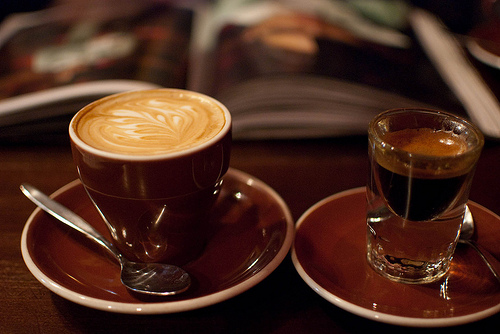

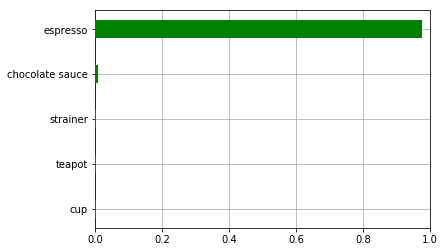

Image class: espresso
Predictions:
class:       espresso	probability:  97.54%
class:chocolate sauce	probability:   0.80%
class:       strainer	probability:   0.36%
class:         teapot	probability:   0.24%
class:            cup	probability:   0.17%

Match!


In [6]:
img_folder = './imagenet-samples/'

conv0_W = conv0_weights['conv0/W']
conv0_T = conv0_weights['conv0/T']
# FC Layer 0
fc0_W = fc_weights['fc0/Wn']
fc0_b = fc_weights['fc0/bn']
# FC Layer 1
fc1_W = fc_weights['fc1/Wn']
fc1_b = fc_weights['fc1/bn']
# FC Layer 2
fct_W = fc_weights['fct/W']

in_dim = net['conv0']['output'][1]
in_ch = net['conv0']['output'][0]
out_dim = net['merge4']['output_dim']
out_ch = net['merge4']['output_channels']

conv_output = classifier.get_accel_buffer(out_ch, out_dim)

while (1):
    for image_name in os.listdir(img_folder):
        img_file = os.path.join(img_folder, image_name)
        img, img_class = classifier.load_image(img_file)
        im = Image.open(img_file)
        # 1st convolutional layer execution, having as input the image and the trained parameters (weights)
        conv0 = utils.conv_layer(img, conv0_W, stride=4)
        # The result in then quantized to 2 bits representation for the subsequent HW offload
        conv0 = utils.threshold(conv0, conv0_T)

        conv_input = classifier.prepare_buffer(conv0)

        # Compute offloaded convolutional layers
        classifier.inference(conv_input, conv_output)
        fc_in = classifier.postprocess_buffer(conv_output)

        # Normalize results
        fc_input = fc_in / np.max(fc_in)
        fc0_out = utils.fully_connected(fc_input, fc0_W, fc0_b)
        fc0_out = utils.qrelu(fc0_out)
        fc0_out = utils.quantize(fc0_out, 2)
        fc1_out = utils.fully_connected(fc0_out, fc1_W, fc1_b)
        fc1_out = utils.qrelu(fc1_out)
        fct_b = np.zeros((fct_W.shape[1], ))
        fct_out = utils.fully_connected(fc1_out, fct_W, fct_b)
        # Softmax
        out = utils.softmax(fct_out)
        # Top-5 results
        topn =  utils.get_topn_indexes(out, 5)  
        x_pos = np.arange(len(topn))
        plt.barh(x_pos, out[topn], height=0.4, color='g', zorder=3)
        plt.yticks(x_pos, [names[k] for k in topn])
        plt.gca().invert_yaxis()
        plt.xlim([0,1])
        plt.grid(zorder=0)
        IPython.display.clear_output(1)
        display(im)
        plt.show()
        if img_class in synsets.keys():
            print("Image class: {:>5}\nPredictions:".format(synsets[img_class]))
            for k in topn: print("class:{0:>15}\tprobability:{1:>8.2%}".format(names[k].lower(), out[k]))
            if synsets[img_class] in (names[k] for k in topn):
                print("\nMatch!")
        else:    
            for k in topn: print("class:{0:>20}\tprobability:{1:>8.2%}".format(names[k].lower(), out[k]))


## Reset the device

In [7]:
classifier.deinit_accelerator()

In [8]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()